# Mounting Drive
Mounting drive to fetch dataset and other resources from the drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Installing Spektral Library


In [ ]:
!pip install git+https://github.com/danielegrattarola/spektral

  Cloning https://github.com/danielegrattarola/spektral to /tmp/pip-req-build-a2p4bbyn
  Running command git clone -q https://github.com/danielegrattarola/spektral /tmp/pip-req-build-a2p4bbyn
  Created wheel for spektral: filename=spektral-1.0.8-py3-none-any.whl size=123417 sha256=1c0e6e389d600bba6468ebce740e3848d6360c910f5377f624328f0d73fb6b1c
  Stored in directory: /tmp/pip-ephem-wheel-cache-xnaqvw1y/wheels/af/7c/1f/e06aba9c0f493bb708968b8b396fe7523fdfb1c1c0818730be
Successfully built spektral


# Loading Label Files

In [ ]:
# Dataset loading
import os

dataset = "/content/drive/MyDrive/Project GCN Dataset/Dataset (Labelled Images)/"
lab_files_path = dataset+"Labels/"

files = os.listdir(lab_files_path)
print("Total Label files are: ", len(files))

Total Label files are:  129


# Sparse Matrix Creation

Iterate all the csv files and do the following three steps:
1. Make a graph of CSV file.
2. Turn the graph into adjacency matrix.
3. Append that adjacency matrix into sparce matrix(i.e. bigger matrix)

# DON'T RUN THIS TAKES A HELL LOT OF TIME
# SPARCE MATRIX IS ALREADY CREATED AND SAVED

In [ ]:
import pandas as pd
import Mat_Package.Grapher as GMaker
import Mat_Package.MatricesOverDiagonal as DiagPlacer
import networkx as nx
import numpy as np
from numpy.core.fromnumeric import shape


Z_file = lab_files_path + files[0]
df = pd.read_csv(Z_file)
G = GMaker.makeGraph(df)
M = nx.to_numpy_array(G, dtype=np.int32)


for i in range(1, len(files)):
    print("\n= = = = = = = = = = = = = = = =")
    print("Iteration No.: ", i)
    # Getting file
    f = lab_files_path + files[i]
    # Making dataframe of file
    df = pd.read_csv(f)
    # Making graph of the dataframe. 
    G = GMaker.makeGraph(df)
    # Storing the graph as an incident matrix(an adjacency matrix)
    I = nx.to_numpy_array(G, dtype=np.int32)
    # Now resizing the original sparce matrix with the new incident matrix
    M = DiagPlacer.resizeMatrix(M, I)
    
print("Final Matix Done")
print("Dimentions of sparce matrix are: ", np.shape(M))


In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
from numpy.core.fromnumeric import shape

# Geometric Algorithms for converting dataframes to Graphs
It connects a node with its neighbouring nodes  

In [ ]:
from PIL.Image import Image
import networkx as nx
from networkx.algorithms.shortest_paths.weighted import single_source_dijkstra
import pandas as pd
import matplotlib.pyplot as plt
from pandas.core.frame import DataFrame
from PIL import Image


# csv = './A-10.csv'
# df = pd.read_csv(csv)
df = 0
xMIN, xMAX = [], []
yMIN, yMAX = [], []
Text = []


def findRight(df, df_ind, xMIN, xMAX, yMIN, yMAX):
    S_list = []
    xmax = xMAX[df_ind]
    ymin = yMIN[df_ind]
    ymax = yMAX[df_ind]

    for i in range(len(df)):
        if(xMIN[i] > xmax):
            if not (yMIN[i] > ymax or yMAX[i] < ymin):
                if(yMIN[i] <= ymin and yMAX[i] <= ymax):
                    S_list.append(i)
                elif (yMIN[i] <= ymin and yMAX[i] >= ymax):
                    S_list.append(i)
                elif (yMIN[i] >= ymin and yMAX[i] <= ymax):
                    S_list.append(i)
                elif (yMIN[i] >= ymin and yMAX[i] >= ymax):
                    S_list.append(i)
                elif (yMIN[i] == ymin and yMAX[i] == ymax):
                    S_list.append(i)

    # print(S_list)
    if S_list:
        consec = S_list[0]
        for j in S_list:
            if(xMIN[consec] > xMIN[j]):
                consec = j
        return consec

    return -1


def findLeft(df, df_ind, xMIN, xMAX, yMIN, yMAX):
    S_list = []
    xmin = xMIN[df_ind]
    ymin = yMIN[df_ind]
    ymax = yMAX[df_ind]

    for i in range(len(df)):
        if(xMAX[i] < xmin):
            if not (yMIN[i] > ymax or yMAX[i] < ymin):
                if(yMIN[i] <= ymin and yMAX[i] <= ymax):
                    S_list.append(i)
                elif (yMIN[i] <= ymin and yMAX[i] >= ymax):
                    S_list.append(i)
                elif (yMIN[i] >= ymin and yMAX[i] <= ymax):
                    S_list.append(i)
                elif (yMIN[i] >= ymin and yMAX[i] >= ymax):
                    S_list.append(i)
                elif (yMIN[i] == ymin and yMAX[i] == ymax):
                    S_list.append(i)
    # print(S_list)
    if S_list:
        consec = S_list[0]
        for j in S_list:
            if(xMAX[j] > xMAX[consec]):
                consec = j
        return consec
    return -1


def findUp(df, df_ind, xMIN, xMAX, yMIN, yMAX):
    S_list = []
    xmin = xMIN[df_ind]
    xmax = xMAX[df_ind]
    ymin = yMIN[df_ind]

    for i in range(len(df)):
        if(yMAX[i] < ymin):
            if not (xMAX[i] < xmin or xMIN[i] > xmax):
                if(xMIN[i] <= xmin and xMAX[i] <= xmax):
                    S_list.append(i)
                elif (xMIN[i] <= xmin and xMAX[i] >= xmax):
                    S_list.append(i)
                elif (xMIN[i] >= xmin and xMAX[i] <= xmax):
                    S_list.append(i)
                elif (xMIN[i] >= xmin and xMAX[i] >= xmax):
                    S_list.append(i)
                elif (xMIN[i] == xmin and xMAX[i] == xmax):
                    S_list.append(i)
    # print(S_list)

    if S_list:
        consec = S_list[0]
        for j in S_list:
            if(yMAX[j] > yMAX[consec]):
                consec = j
        return consec

    return -1


def findDown(df, df_ind, xMIN, xMAX, yMIN, yMAX):
    S_list = []
    xmin = xMIN[df_ind]
    xmax = xMAX[df_ind]
    ymax = yMAX[df_ind]

    for i in range(len(df)):
        if(yMIN[i] > ymax):
            if not (xMAX[i] < xmin or xMIN[i] > xmax):
                if(xMIN[i] <= xmin and xMAX[i] <= xmax):
                    S_list.append(i)
                elif (xMIN[i] <= xmin and xMAX[i] >= xmax):
                    S_list.append(i)
                elif (xMIN[i] >= xmin and xMAX[i] <= xmax):
                    S_list.append(i)
                elif (xMIN[i] >= xmin and xMAX[i] >= xmax):
                    S_list.append(i)
                elif (xMIN[i] == xmin and xMAX[i] == xmax):
                    S_list.append(i)
    # print(S_list)
    if S_list:
        consec = S_list[0]
        for j in S_list:
            if(yMIN[j] < yMIN[consec]):
                consec = j
        return consec

    return -1


def makeGraph(df):
    G = nx.Graph()
    xMIN = df['xmin']
    xMAX = df['xmax']
    yMIN = df['ymin']
    yMAX = df['ymax']
    Text = df['Object']

    for i in range(len(df)):
        if findUp(df, i, xMIN, xMAX, yMIN, yMAX):
            l = findUp(df, i, xMIN, xMAX, yMIN, yMAX)
            if(l != -1):
                text = Text[l]
                G.add_edge(Text[i], text)
        if findRight(df, i, xMIN, xMAX, yMIN, yMAX):
            l = findRight(df, i, xMIN, xMAX, yMIN, yMAX)
            if (l != -1):
                text = Text[l]
                G.add_edge(Text[i], text)
        if findDown(df, i, xMIN, xMAX, yMIN, yMAX):
            l = findDown(df, i, xMIN, xMAX, yMIN, yMAX)
            if (l != -1):
                text = Text[l]
                G.add_edge(Text[i], text)
        if findLeft(df, i, xMIN, xMAX, yMIN, yMAX):
            l = findLeft(df, i, xMIN, xMAX, yMIN, yMAX)
            if (l != -1):
                text = Text[l]
                G.add_edge(Text[i], text)
    return G


# Matrices Over Diagonal
Place an incident Matrix over diagonal with existing matrix

In [ ]:
from typing import SupportsAbs
import numpy as np
from numpy.core.fromnumeric import shape

# Test Matrices
# mat1 = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
# mat2 = np.array([[3, 2, 1, 7], [6, 5, 4, 9], [9, 8, 7, 4], [1, 5, 7, 2]])


def alignDiagonally(M1, M2, prev_Len):
    for i in range(prev_Len, np.shape(M1)[0]):
        for j in range(prev_Len, np.shape(M1)[0]):
            x = i - prev_Len
            y = j - prev_Len
            M1[i][j] = M2[x][y]
    return M1


def resizeMatrix(M, I):
    oldMat_Len = np.shape(M)[0]
    z = np.zeros((oldMat_Len, np.shape(I)[0]), dtype=np.int64)
    newArray = np.append(M, z, axis=1)
    M = newArray

    # Appending 1D arrays of zeros in the original Matrix
    # (i.e. the matrix in which we want to align othe rmatrices diagonally)
    # for i in range(appZero):
    #     M = np.vstack((M, L))
    appZero = np.shape(I)[0]
    x = oldMat_Len + appZero
    L = np.zeros((np.shape(I)[0], x), dtype=np.int64)
    newArray = np.append(M, L, axis=0)
    M = newArray

    M = alignDiagonally(M, I, oldMat_Len)
    return M


# print(resizeMatrix(mat1, mat2))


# Dividing Dataset into smaller datasets
Creating a total of four sparse matrices and saving it to drive. 

# Dataset Batch 1

In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
from numpy.core.fromnumeric import shape

Z_file = lab_files_path + files[0]
df = pd.read_csv(Z_file)
G = makeGraph(df)
M1 = nx.to_numpy_array(G, dtype=np.int32)

for i in range(1, 26):
    print("\n= = = = = = = = = = = = = = = =")
    print("Iteration No.: ", i)
    # Getting file
    f = lab_files_path + files[i]
    # Making dataframe of file
    df = pd.read_csv(f)
    # Making graph of the dataframe. 
    G = makeGraph(df)
    # Storing the graph as an incident matrix(an adjacency matrix)
    I = nx.to_numpy_array(G, dtype=np.int32)
    # Now resizing the original sparce matrix with the new incident matrix
    M1 = resizeMatrix(M1, I)

print("Dimentions of Batch 1 matrix is: ", np.shape(M1))


= = = = = = = = = = = = = = = =
Iteration No.:  1

= = = = = = = = = = = = = = = =
Iteration No.:  2

= = = = = = = = = = = = = = = =
Iteration No.:  3

= = = = = = = = = = = = = = = =
Iteration No.:  4

= = = = = = = = = = = = = = = =
Iteration No.:  5

= = = = = = = = = = = = = = = =
Iteration No.:  6

= = = = = = = = = = = = = = = =
Iteration No.:  7

= = = = = = = = = = = = = = = =
Iteration No.:  8

= = = = = = = = = = = = = = = =
Iteration No.:  9

= = = = = = = = = = = = = = = =
Iteration No.:  10

= = = = = = = = = = = = = = = =
Iteration No.:  11

= = = = = = = = = = = = = = = =
Iteration No.:  12

= = = = = = = = = = = = = = = =
Iteration No.:  13

= = = = = = = = = = = = = = = =
Iteration No.:  14

= = = = = = = = = = = = = = = =
Iteration No.:  15

= = = = = = = = = = = = = = = =
Iteration No.:  16

= = = = = = = = = = = = = = = =
Iteration No.:  17

= = = = = = = = = = = = = = = =
Iteration No.:  18

= = = = = = = = = = = = = = = =
Iteration No.:  19

= = = = = = = = = = 

# Dataset Batch 2

In [ ]:
Z1_file = lab_files_path + files[26]
df = pd.read_csv(Z1_file)
G = makeGraph(df)
M2 = nx.to_numpy_array(G, dtype=np.int32)

for i in range(27, 65):
    print("\n= = = = = = = = = = = = = = = =")
    print("Iteration No.: ", i)
    # Getting file
    f = lab_files_path + files[i]
    # Making dataframe of file
    df = pd.read_csv(f)
    # Making graph of the dataframe. 
    G = makeGraph(df)
    # Storing the graph as an incident matrix(an adjacency matrix)
    I = nx.to_numpy_array(G, dtype=np.int32)
    # Now resizing the original sparce matrix with the new incident matrix
    M2 = resizeMatrix(M2, I)

print("Dimentions of Batch 2 matrix is: ", np.shape(M2))  


= = = = = = = = = = = = = = = =
Iteration No.:  27

= = = = = = = = = = = = = = = =
Iteration No.:  28

= = = = = = = = = = = = = = = =
Iteration No.:  29

= = = = = = = = = = = = = = = =
Iteration No.:  30

= = = = = = = = = = = = = = = =
Iteration No.:  31

= = = = = = = = = = = = = = = =
Iteration No.:  32

= = = = = = = = = = = = = = = =
Iteration No.:  33

= = = = = = = = = = = = = = = =
Iteration No.:  34

= = = = = = = = = = = = = = = =
Iteration No.:  35

= = = = = = = = = = = = = = = =
Iteration No.:  36

= = = = = = = = = = = = = = = =
Iteration No.:  37

= = = = = = = = = = = = = = = =
Iteration No.:  38

= = = = = = = = = = = = = = = =
Iteration No.:  39

= = = = = = = = = = = = = = = =
Iteration No.:  40

= = = = = = = = = = = = = = = =
Iteration No.:  41

= = = = = = = = = = = = = = = =
Iteration No.:  42

= = = = = = = = = = = = = = = =
Iteration No.:  43

= = = = = = = = = = = = = = = =
Iteration No.:  44

= = = = = = = = = = = = = = = =
Iteration No.:  45

= = = = = =

# Dataset Batch 3

In [ ]:
Z2_file = lab_files_path + files[65]
df = pd.read_csv(Z2_file)
G = makeGraph(df)
M3 = nx.to_numpy_array(G, dtype=np.int32)
    
for i in range(66, 100):
    print("\n= = = = = = = = = = = = = = = =")
    print("Iteration No.: ", i)
    # Getting file
    f = lab_files_path + files[i]
    # Making dataframe of file
    df = pd.read_csv(f)
    # Making graph of the dataframe. 
    G = makeGraph(df)
    # Storing the graph as an incident matrix(an adjacency matrix)
    I = nx.to_numpy_array(G, dtype=np.int32)
    # Now resizing the original sparce matrix with the new incident matrix
    M3 = resizeMatrix(M3, I)

print("Dimentions of Batch 3 matrix is: ", np.shape(M3))


= = = = = = = = = = = = = = = =
Iteration No.:  66

= = = = = = = = = = = = = = = =
Iteration No.:  67

= = = = = = = = = = = = = = = =
Iteration No.:  68

= = = = = = = = = = = = = = = =
Iteration No.:  69

= = = = = = = = = = = = = = = =
Iteration No.:  70

= = = = = = = = = = = = = = = =
Iteration No.:  71

= = = = = = = = = = = = = = = =
Iteration No.:  72

= = = = = = = = = = = = = = = =
Iteration No.:  73

= = = = = = = = = = = = = = = =
Iteration No.:  74

= = = = = = = = = = = = = = = =
Iteration No.:  75

= = = = = = = = = = = = = = = =
Iteration No.:  76

= = = = = = = = = = = = = = = =
Iteration No.:  77

= = = = = = = = = = = = = = = =
Iteration No.:  78

= = = = = = = = = = = = = = = =
Iteration No.:  79

= = = = = = = = = = = = = = = =
Iteration No.:  80

= = = = = = = = = = = = = = = =
Iteration No.:  81

= = = = = = = = = = = = = = = =
Iteration No.:  82

= = = = = = = = = = = = = = = =
Iteration No.:  83

= = = = = = = = = = = = = = = =
Iteration No.:  84

= = = = = =

# Dataset Batch 4


In [ ]:
Z3_file = lab_files_path + files[100]
df = pd.read_csv(Z3_file)
G = makeGraph(df)
M4 = nx.to_numpy_array(G, dtype=np.int32)

for i in range(101, len(files)):
    print("\n= = = = = = = = = = = = = = = =")
    print("Iteration No.: ", i)
    # Getting file
    f = lab_files_path + files[i]
    # Making dataframe of file
    df = pd.read_csv(f)
    # Making graph of the dataframe. 
    G = makeGraph(df)
    # Storing the graph as an incident matrix(an adjacency matrix)
    I = nx.to_numpy_array(G, dtype=np.int32)
    # Now resizing the original sparce matrix with the new incident matrix
    M4 = resizeMatrix(M4, I)

print("Dimentions of Batch 4 matrix is: ", np.shape(M4))



= = = = = = = = = = = = = = = =
Iteration No.:  101

= = = = = = = = = = = = = = = =
Iteration No.:  102

= = = = = = = = = = = = = = = =
Iteration No.:  103

= = = = = = = = = = = = = = = =
Iteration No.:  104

= = = = = = = = = = = = = = = =
Iteration No.:  105

= = = = = = = = = = = = = = = =
Iteration No.:  106

= = = = = = = = = = = = = = = =
Iteration No.:  107

= = = = = = = = = = = = = = = =
Iteration No.:  108

= = = = = = = = = = = = = = = =
Iteration No.:  109

= = = = = = = = = = = = = = = =
Iteration No.:  110

= = = = = = = = = = = = = = = =
Iteration No.:  111

= = = = = = = = = = = = = = = =
Iteration No.:  112

= = = = = = = = = = = = = = = =
Iteration No.:  113

= = = = = = = = = = = = = = = =
Iteration No.:  114

= = = = = = = = = = = = = = = =
Iteration No.:  115

= = = = = = = = = = = = = = = =
Iteration No.:  116

= = = = = = = = = = = = = = = =
Iteration No.:  117

= = = = = = = = = = = = = = = =
Iteration No.:  118

= = = = = = = = = = = = = = = =
Iteration No.

# Verifying dataset batches size

In [ ]:
t_size = np.shape(M1)[0] + np.shape(M2)[0]  + np.shape(M3)[0] + np.shape(M4)[0] 
print("Overall dimention is: ", t_size)

Overall dimention is:  21097


# Saving the four Matrices
Saving the matrices named Mat_batch(no.)

In [ ]:
np.save("drive/MyDrive/Project GCN Dataset/Mat_b1.npy", M1)
np.save("drive/MyDrive/Project GCN Dataset/Mat_b2.npy", M2)
np.save("drive/MyDrive/Project GCN Dataset/Mat_b3.npy", M3)
np.save("drive/MyDrive/Project GCN Dataset/Mat_b4.npy", M4)

# Saving Matrix

# MATRIX ALREADY SAVED
# PLEASE DONOT RUN THIS CELL

In [ ]:
print("Saving Matrix")
np.save("drive/MyDrive/Project GCN Dataset/Matrix.npy", M)

print("Saved")

# Loading Matrix
Loading the sparce matrix in a variable A.

In [ ]:
import numpy as np

# loading matrix
A1 = np.load("/content/drive/MyDrive/Project GCN Dataset/Mat_b1.npy")
A2 = np.load("/content/drive/MyDrive/Project GCN Dataset/Mat_b2.npy")
A3 = np.load("/content/drive/MyDrive/Project GCN Dataset/Mat_b3.npy")
A4 = np.load("/content/drive/MyDrive/Project GCN Dataset/Mat_b4.npy")
print("Printing Sparse Matrix..")
print(A1)
print(A2)
print(A3)
print(A4)
print(np.shape(A1))
print(np.shape(A2))
print(np.shape(A3))
print(np.shape(A4))

Printing Sparse Matrix..
[[0 1 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]]
[[1 1 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 1 0]]
[[0 1 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 1 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 1 0]]
(5762, 5762)
(5410, 5410)
(7432, 7432)
(2493, 2493)


# Checking Sparse Matrix

(5762, 5762)
(5410, 5410)
(7432, 7432)
(2493, 2493)


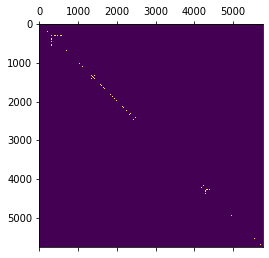

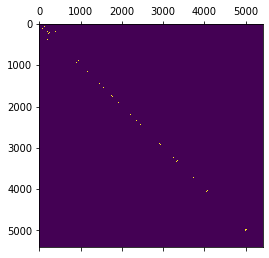

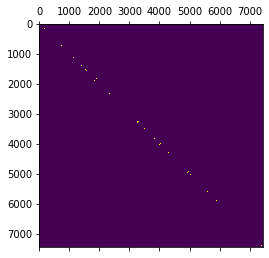

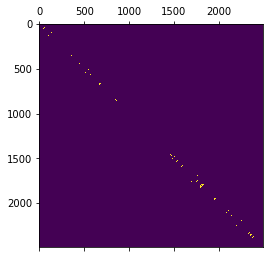

In [ ]:
import matplotlib.pyplot as plt

plt.matshow(A1)
plt.matshow(A2)
plt.matshow(A3)

print(np.shape(A1))
print(np.shape(A2))
print(np.shape(A3))
print(np.shape(A4))

# Generating Labels

In [ ]:
from numpy import nan
import pandas as pd


def returnLabels(direc, files):
    labels = []
    for f in range(len(files)):
        seenList = []
        df = pd.read_csv(direc + files[f])
        text = df['Object'].to_list()
        T_labels = df['labels'].to_list()

        for i in range(len(text)):
            if(text[i] not in seenList):
                labels.append(T_labels[i])
            seenList.append(text[i])

    return labels
  


# Encoding Labels
1. Get a list of labels from CSV files.
2. Catagorically encode the labels 

In [ ]:
from sklearn.preprocessing import LabelEncoder

labels = returnLabels(lab_files_path, files)
print("Total labels are: ", len(labels))

print("Encoding list..")
lab_encoder = LabelEncoder()
encodings = lab_encoder.fit_transform(labels)
print("Total Encodings are: ", len(encodings))


# t_file = open("Encodings.txt", "w")
# for element in encodings:
#     t_file.write("%i\n" % element)

# t_file.close()


uni_enc = set(encodings)
print("Unique Encodings are: ", uni_enc)
encodings = np.transpose(encodings)  

# Encodings for Mat_b1 are
e1_encodings_size = np.shape(A1)[0]
print("Size of batch1 matrix is: ", e1_encodings_size)
e1 = encodings[0:e1_encodings_size]
print("Total encodings for batch1 matrix are: ", len(e1))

# Encodings for Mat_b2 are
e2_encodings_size = np.shape(A2)[0]
print("Size of batch1 matrix is: ", e1_encodings_size)
e2 = encodings[e1_encodings_size:e2_encodings_size+e1_encodings_size]
print("Total encodings for batch2 matrix are: ", len(e2))

# Encodings for Mat_b3 are
e3_encodings_size = np.shape(A3)[0]
start = e2_encodings_size+e1_encodings_size 
print("Size of batch1 matrix is: ", e1_encodings_size)
e3 = encodings[start:start+e3_encodings_size]
print("Total encodings for batch3 matrix are: ", len(e3))

# Encodings for Mat_b4 are
e4_encodings_size = np.shape(A4)[0]
start += e3_encodings_size
print("Size of batch1 matrix is: ", e1_encodings_size)
e4 = encodings[start:start+e4_encodings_size]
print("Total encodings for batch4 matrix are: ", len(e4))

print("Total length", (len(e1) + len(e2) + len(e3) +len(e4)))

print("Encodings for Batch 1 Matrix is: ", set(e1))


Total labels are:  21097
Encoding list..
Total Encodings are:  21097
Unique Encodings are:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
Size of batch1 matrix is:  5762
Total encodings for batch1 matrix are:  5762
Size of batch1 matrix is:  5762
Total encodings for batch2 matrix are:  5410
Size of batch1 matrix is:  5762
Total encodings for batch3 matrix are:  7432
Size of batch1 matrix is:  5762
Total encodings for batch4 matrix are:  2493
Total length 21097
Encodings for Batch 1 Matrix is:  {2, 3, 5, 6, 8, 9, 10, 11}


# Importing Libraries

In [ ]:
from sklearn.utils import shuffle

# from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten, MaxPool2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2


from spektral.utils.sparse import sp_matrix_to_sp_tensor
from spektral.layers import GCNConv
from sklearn.metrics import classification_report
from spektral.utils import normalized_laplacian
from spektral.utils.sparse import sp_matrix_to_sp_tensor

import matplotlib.pyplot as plt
print("Libraries Imported..")


Libraries Imported..


# Model Hyper-parameters
Adding model hyper-parameters:
1. Learning rate(At whar pace should the model be learning)
2. Channels(Neurons)
3. Dropout rate(Now many neurons should be active at a time)
4. Epochs(How many times a data is passed through the model)
5. Batch size(How much data should be fed to the model at a time)
etc

In [ ]:
# Hyper-parameters

channels = 32
dropout = 0.5
# learning_rate = 5e-4
l2_reg = 0.001
learning_rate = 0.005
epochs = 200
batch_size = 5762
es_patience = 10

out_classes = 12


# Getting Node Features



In [ ]:
import numpy as np
import networkx as nx


def nodeFeatures(A):
    # X = Features Matrix
    X = np.matrix([[i, -i] for i in range(A.shape[0])], dtype=float)
    print("Printing Feature Matrix..")
    print(X)

    # Identity matrix of the same shape as adjacency matrix
    I = np.matrix(np.eye(A.shape[0]))

    # Self looping making node connections with themselves
    # i.e. multiply the adjacency matrix with identity matrix
    A_new = A + I

    # Multiplying the self-looped graph with the feature matrix

    # Stores the sum of array(Row wise) in a new array called D
    D = np.array(np.sum(A, axis=0))[0]

    # Making the diagonal matrix named D containing the elements of 1D array D
    # D = np.matrix(np.diag(D))
    # print("Printing the 2D array named D containing the elemnets of 1D D in diagonal")
    # print(D)

    # Stores the degree of the graph in a 1D array called D
    D = np.array(np.sum(A_new, axis=0))[0]
    # Transforming that 1D array to a degree matrix
    D = np.matrix(np.diag(D))
    # print("Degree matrix of A_new multiplied by A_new..")
    D_new = D * A_new
    # print(D_new)

    # Weight Matrix
    W0 = np.random.randn(X.shape[1], 8) * 0.01

    print("Printing Weights")
    print(W0)

    # Reducing feature of output feature representation..
    print("Output feature representation..")
    final = D_new**-1 * A_new * X * W0

    def relu(x):
        return np.maximum(0, x)

    H_1 = relu(final)
    # print("After applying relu function..")
    # print(H_1)

    output = H_1

    # print("Printing A_new matrix..")
    # print(A_new)

    G = nx.from_numpy_matrix(np.array(A_new))
    # nx.draw_networkx_edges(G, pos=nx.spring_layout(
    #     G), arrowstyle="<|-", style="dashed")
    # plt.show()
    # nx.draw(G)
    # plt.savefig("/content/Sample Graph.png")
    feature_representations = {
        node: np.array(output)[node]
        for node in G.nodes()
    }

    features = np.array(feature_representations.values())

    # print("Printing feature representation..")
    # print(features)

    vals = []

    for v in feature_representations.values():
        vals.append(v)

    vals = np.array(vals)

    # print("Prining features in an array", vals)

    # print("Shape of vals is: ", np.shape(vals))

    return vals


Printing Feature Matrix..
[[ 0.000e+00  0.000e+00]
 [ 1.000e+00 -1.000e+00]
 [ 2.000e+00 -2.000e+00]
 ...
 [ 5.407e+03 -5.407e+03]
 [ 5.408e+03 -5.408e+03]
 [ 5.409e+03 -5.409e+03]]
Output feature representation..
Prining features in an array [[7.81826347e-01 7.45754333e-01 6.21740461e-01 ... 1.34043824e-01
  5.78167018e-01 0.00000000e+00]
 [9.37306322e-01 8.94060750e-01 7.45384530e-01 ... 1.60700806e-01
  6.93145738e-01 0.00000000e+00]
 [9.12960703e-02 8.70838393e-02 7.26023892e-02 ... 1.56526759e-02
  6.75141953e-02 0.00000000e+00]
 ...
 [8.97149884e+01 8.55757055e+01 7.13450479e+01 ... 1.53816000e+01
  6.63449722e+01 0.00000000e+00]
 [8.97398873e+01 8.55994557e+01 7.13648485e+01 ... 1.53858689e+01
  6.63633851e+01 0.00000000e+00]
 [8.97772357e+01 8.56350809e+01 7.13945495e+01 ... 1.53922723e+01
  6.63910046e+01 0.00000000e+00]]
Shape of vals is:  (5410, 8)


# Model Definition
3 GCN-Conv Layers & 2 Dense Layers

In [ ]:

def model(M):
    N = M.shape[0]
    F = nodeFeatures(M).shape[1]

    # print("Node has ", F, " features")
    # print("Total Nodes are: ", N)

    fltr = normalized_laplacian(M)
    X_in = Input(batch_size = N, shape=(F))
    # print("Shape of X-in is: ", np.shape(X_in))

    A_in = Input(tensor=sp_matrix_to_sp_tensor(fltr))
    # print("Shape of A-in is: ", np.shape(A_in))

    G1 = GCNConv(channels, activation='LeakyReLU', kernel_regularizer=l2(l2_reg), use_bias=True)([X_in, A_in])

    G2 = GCNConv(channels, activation='LeakyReLU', kernel_regularizer=l2(l2_reg), use_bias=True)([G1, A_in])

    flatten = Flatten()(G2)

    D1 = Dense(512, activation='LeakyReLU')(flatten)

    D2 = Dense(32, activation='LeakyReLU')(D1)


    D2_out = Dense(out_classes, activation='softmax')(D2)

    model = Model(inputs = [X_in, A_in], outputs=D2_out)
    model.compile(optimizer = 'Adagrad', loss = 'sparse_categorical_crossentropy', weighted_metrics=['acc'])

    model.summary()


Node has  8  features
Total Nodes are:  7432
Shape of X-in is:  (7432, 8)
Shape of A-in is:  (7432, 7432)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(7432, 8)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(7432, 7432)]       0                                            
__________________________________________________________________________________________________
gcn_conv_2 (GCNConv)            (None, 32)           288         input_3[0][0]                    
                                                                 input_4[0][0]                    
_____________________________________________________________________________________

# Training Model

In [ ]:
print(np.shape(vals))

# {2, 3, 5, 6, 8, 9, 10, 11}
W = {
    0:np.random.rand(),
    1:np.random.rand(),
    2:np.random.rand(),
    3:np.random.rand(),
    4:np.random.rand(),
    5:np.random.rand(),
    6:np.random.rand(),
    7:np.random.rand(),
    8:np.random.rand(),
    9:np.random.rand(),
    10:np.random.rand(),
    11:np.random.rand(),
}
model.fit([vals, A2],
          e2,
          epochs = 200,
          batch_size = N,
          class_weight=W,
          )

(5410, 8)
Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 34.4828 - acc: 0.0062
Epoch 2/200
1/1 [==============================] - 1s 590ms/step - loss: 19.7347 - acc: 0.0720
Epoch 3/200
1/1 [==============================] - 0s 453ms/step - loss: 6.3650 - acc: 0.0829
Epoch 4/200
1/1 [==============================] - 0s 463ms/step - loss: 5.4524 - acc: 0.0000e+00
Epoch 5/200
1/1 [==============================] - 0s 448ms/step - loss: 4.5552 - acc: 0.0727
Epoch 6/200
1/1 [==============================] - 0s 462ms/step - loss: 14.7480 - acc: 0.2936
Epoch 7/200
1/1 [==============================] - 0s 452ms/step - loss: 5.7590 - acc: 0.2270
Epoch 8/200
1/1 [==============================] - 0s 461ms/step - loss: 6.4748 - acc: 0.2936
Epoch 9/200
1/1 [==============================] - 0s 447ms/step - loss: 7.1631 - acc: 0.1788
Epoch 10/200
1/1 [==============================] - 0s 439ms/step - loss: 2.4600 - acc: 0.0829
Epoch 11/200
1/1 [===========================

# Saving Model

In [ ]:
model.save("/content/drive/MyDrive/Project GCN Dataset/IDS_Batch1_0.9267.h5")